<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import open_finam_data
from datetime import datetime

In [13]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline

# Получение данных свечей

In [2]:
tolls_path_list = ['HYDR_200101_200425.csv','YNDX_200101_200425.csv']
df_dikt = {}
for toll_path in tolls_path_list:
    df = open_fnam_data.open('../../input/' + toll_path)
    #  Фильтр дат
    df = df.loc[df.index >= '2020-04-20']
    df_dikt[toll_path.split('_')[0]] = df

In [3]:
df= df_dikt['HYDR']
df

,OPEN,HIGH,LOW,CLOSE,VOL
DATE_TIME,,,,,
2020-04-20 10:01:00,0.6151,0.6160,0.6124,0.6145,14188000
2020-04-20 10:02:00,0.6141,0.6153,0.6137,0.6149,1507000
2020-04-20 10:03:00,0.6148,0.6148,0.6137,0.6140,1779000
2020-04-20 10:04:00,0.6141,0.6158,0.6141,0.6158,2144000
2020-04-20 10:05:00,0.6156,0.6169,0.6156,0.6166,2778000
...,...,...,...,...,...
2020-04-24 18:40:00,0.6145,0.6154,0.6145,0.6149,3493000
2020-04-24 18:46:00,0.6118,0.6118,0.6118,0.6118,38239000
2020-04-24 18:47:00,0.6118,0.6118,0.6118,0.6118,759000


# Определяем период который перекрывают все инструменты

In [4]:
data_period_dick = {'stert':[], 'end':[], 'step' : []}
for tool in list(df_dikt):
    data_period_dick['stert'].append(df_dikt[tool].index[0])
    data_period_dick['end'].append(df_dikt[tool].index[-1])
    data_period_dick['step'].append(df_dikt[tool].index[1] - df_dikt[tool].index[0])
data_period_dick['stert'] = max(data_period_dick['stert'])
data_period_dick['end'] = min(data_period_dick['end'])
data_period_dick['step'] = data_period_dick['step'][0]
data_period_dick

{'stert': Timestamp('2020-04-20 10:01:00'),
 'end': Timestamp('2020-04-24 18:50:00'),
 'step': Timedelta('0 days 00:01:00')}

In [5]:
# Словарь с котировами по цене закрытия на инструменты нахдящиеся в работе
cot_dict = {}
for tool in list(df_dikt):
    cot_dict[tool] = 0
cot_dict

{'HYDR': 0, 'YNDX': 0}

# Ресэмплирование

In [6]:
for tool in list(df_dikt):
    df_dikt[tool] = df_dikt[tool].resample(data_period_dick['step']).last()

In [7]:
# Создание диапазана
data_time_range = pd.date_range(start = data_period_dick['stert'], end = data_period_dick['end'], freq = data_period_dick['step'])

In [8]:
# Создание данных о стоимости портфеля
portfel_df = pd.DataFrame(index=data_time_range)
portfel_df['Portfel_vol'] = portfel_df.apply(lambda x: 0, axis = 1)
portfel_df

,Portfel_vol
2020-04-20 10:01:00,0
2020-04-20 10:02:00,0
2020-04-20 10:03:00,0
2020-04-20 10:04:00,0
2020-04-20 10:05:00,0
...,...
2020-04-24 18:46:00,0
2020-04-24 18:47:00,0
2020-04-24 18:48:00,0
2020-04-24 18:49:00,0


# Тестирование на исторических данных

In [9]:
import financial_account
my_account = financial_account.Financial_account()
my_account.add_mone(100000)
data_null = data_time_range[0]
data_prise = data_null

for data_time in data_time_range:
#   Определение акруальных котировок
    for tool in list(cot_dict):
        cot_dict[tool] = df_dikt[tool].iloc[df_dikt[tool].index == data_time]['CLOSE'].values[0]
    if data_time == pd.Timestamp('2020-04-21 10:01:00'):
        my_account.buy_lot(lot_name = 'HYDR',lot_count = 10, lot_size = 1000, lot_price = cot_dict['HYDR'])
    if data_time == pd.Timestamp('2020-04-22 12:00:00'):
        my_account.sell_lot(lot_name = 'HYDR',lot_count = 10, lot_size = 1000, lot_price = cot_dict['HYDR'])
        
    portfel_df.loc[portfel_df.index == data_time] = my_account.get_portfel_price(cot_dict)

my_account.free_money



100389.05834999999

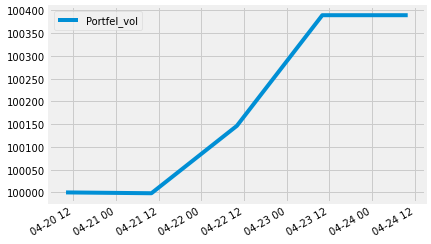

In [15]:
portfel_df.asfreq('D').plot()